In [44]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import yaml
import os
import logging
from contextlib import nullcontext
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from xgboost import XGBRFRegressor
import yaml

In [2]:
logging.basicConfig(level=logging.INFO)
logger=logging.getLogger()

In [3]:
mlflow_tracking_uri='http://localhost:5555'

In [8]:
data_path='../data/processed/featured_house_data.csv'
data=pd.read_csv(filepath_or_buffer=data_path)
X=data.drop(labels=['price'],axis=1)
y=data['price']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
xgb_model=XGBRFRegressor(objective='reg:squarederror')

In [15]:
xgb_model.fit(X=X_train,y=y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, ...)

In [16]:
rfe_selector=RFE(estimator=xgb_model,n_features_to_select=10)

In [17]:
rfe_selector.fit(X=X_train,y=y_train)

RFE(estimator=XGBRFRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bytree=None,
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=None, gpu_id=None,
                             grow_policy=None, importance_type=None,
                             interaction_constraints=None, max_bin=None,
                             max_cat_threshold=None, max_cat_to_onehot=None,
                             max_delta_step=None, max_depth=None,
                             max_leaves=None, min_child_weight=None,
                             missing=nan, monotone_constraints=None,
                             n_estimators=100, n_jobs=None,
                             num_parallel_tree=None,
                             objective='reg:squarederror', predictor=None,
                             random_state=None, reg_alpha=None, ...),
    n_features_to_select=10)

In [20]:
rfe_selector.support_

array([ True,  True,  True,  True,  True, False,  True, False,  True,
        True, False, False,  True, False,  True, False])

In [19]:
X.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15'],
      dtype='object')

In [21]:
rfe_selected_features=X.columns[rfe_selector.support_]
rfe_selected_features

Index(['0', '1', '2', '3', '4', '6', '8', '9', '12', '14'], dtype='object')

In [22]:
rfe_ignored_features=X.columns[~rfe_selector.support_]
rfe_ignored_features

Index(['5', '7', '10', '11', '13', '15'], dtype='object')

In [24]:
selected_features_dict={'rfe':list(rfe_selected_features)}

In [25]:
X_train=X_train[rfe_selected_features]
X_test=X_test[rfe_selected_features]

In [26]:
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(uri=mlflow_tracking_uri)
    mlflow.set_experiment(experiment_name="House Price Prediction Experiment")

2025/11/19 18:26:42 INFO mlflow.tracking.fluent: Experiment with name 'House Price Prediction Experiment' does not exist. Creating a new experiment.


In [27]:
models={
    'LinearRegression':LinearRegression(),
    'RandomForest':RandomForestRegressor(),
    'GradientBoosting':GradientBoostingRegressor(),
    'XGBoost':xgb.XGBRegressor(objective='reg:squarederror')
}

In [28]:
model_grid={
    'LinearRegression':{},
    'RandomForest':{
        'n_estimators':[100,150],
        'max_depth':[None, 10, 20]
    },
    'GradientBoosting':{
        'n_estimators':[100,250],
        'learning_rate':[0.1,0.05],
        'max_depth':[3,10]
    },
    'XGBoost':{
        'n_estimators':[100,150],
        'learning_rate':[0.1,0.05],
        'max_depth':[3,10]
    }
}

In [37]:
def evaluate_model_with_gridsearch(name:str,model, grid, x_train, y_train, x_test, y_test):
    if grid:
        clf=GridSearchCV(estimator=model,
                         param_grid=grid,
                         cv=4,
                         scoring='r2',
                         n_jobs=-1
                        )
        clf.fit(X=X_train,y=y_train)
        best_model=clf.best_estimator_
        best_params=clf.best_params_
    else:
        model.fit(X=X_train,y=y_train)
        best_model=model
        best_params=model.get_params()

    y_pred=best_model.predict(X_test)
    mae=mean_absolute_error(y_true=y_test,y_pred=y_pred)
    mse=mean_squared_error(y_true=y_test,y_pred=y_pred)
    rmse=np.sqrt(mse)
    r2=r2_score(y_true=y_test,y_pred=y_pred)

    return {
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        'r2':r2,
        'model':best_model,
        'params':best_params
    }
    print(f'MLFlow tracking URI:{mlflow_tracking_uri}')

In [38]:
results={}
with mlflow.start_run(run_name="model_comparision") if mlflow_tracking_uri else nullcontext():
    for name,model in models.items():
        logger.info(f"Training {name}...")
        with mlflow.start_run(run_name=name, nested=True) if mlflow_tracking_uri else nullcontext():
            evaluation=evaluate_model_with_gridsearch(
                name=name,model=model,
                grid=model_grid[name],
                x_train=X_train,
                x_test=X_test,
                y_train=y_train,
                y_test=y_test
            )
            results[name]=evaluation
            if mlflow_tracking_uri:
                mlflow.log_params(params=evaluation['params'])
                mlflow.log_metrics(metrics={
                    'mae':evaluation['mae'],
                    'mse':evaluation['mse'],
                    'rmse':evaluation['rmse'],
                    'r2':evaluation['r2']                    
                })
                mlflow.sklearn.log_model(
                    sk_model=evaluation['model'],
                    artifact_path=name.lower().replace(" ","_")
                )
            print(f"{name} R2:{evaluation['r2']:.4f}, RMSE:{evaluation['rmse']:.2f}")

INFO:root:Training LinearRegression...
D:\MLOPS\MLOPS_Udemy\House_Price_Predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/11/19 20:54:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training RandomForest...


LinearRegression R2:0.9703, RMSE:37215.42


D:\MLOPS\MLOPS_Udemy\House_Price_Predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/11/19 20:54:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training GradientBoosting...


RandomForest R2:0.9887, RMSE:22954.40


D:\MLOPS\MLOPS_Udemy\House_Price_Predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/11/19 20:54:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training XGBoost...


GradientBoosting R2:0.9939, RMSE:16806.23


D:\MLOPS\MLOPS_Udemy\House_Price_Predictor\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2025/11/19 20:54:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


XGBoost R2:0.9778, RMSE:32190.45


In [39]:
results

{'LinearRegression': {'mae': 14502.004750208878,
  'mse': 1384987839.164356,
  'rmse': 37215.42474786974,
  'r2': 0.9702661106810413,
  'model': LinearRegression(),
  'params': {'copy_X': True,
   'fit_intercept': True,
   'n_jobs': None,
   'positive': False}},
 'RandomForest': {'mae': 14051.875,
  'mse': 526904343.75,
  'rmse': 22954.397046099904,
  'r2': 0.9886880483743498,
  'model': RandomForestRegressor(),
  'params': {'max_depth': None, 'n_estimators': 100}},
 'GradientBoosting': {'mae': 9722.979622028652,
  'mse': 282449400.7020547,
  'rmse': 16806.231008231876,
  'r2': 0.9939361783683615,
  'model': GradientBoostingRegressor(n_estimators=250),
  'params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}},
 'XGBoost': {'mae': 17577.810546875,
  'mse': 1036225323.8904419,
  'rmse': 32190.453924889625,
  'r2': 0.977753588718403,
  'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
         

In [40]:
def plot_model_metrics(results, metric='r2'):
    names=list(results.keys())
    values=[results[name][metric] for name in names]

    plt.figure(figsize=(10,6))
    plt.bar(names, values)
    plt.title(f"Model Comparision by {metric.upper()}")
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(visible=True)
    plt.show()

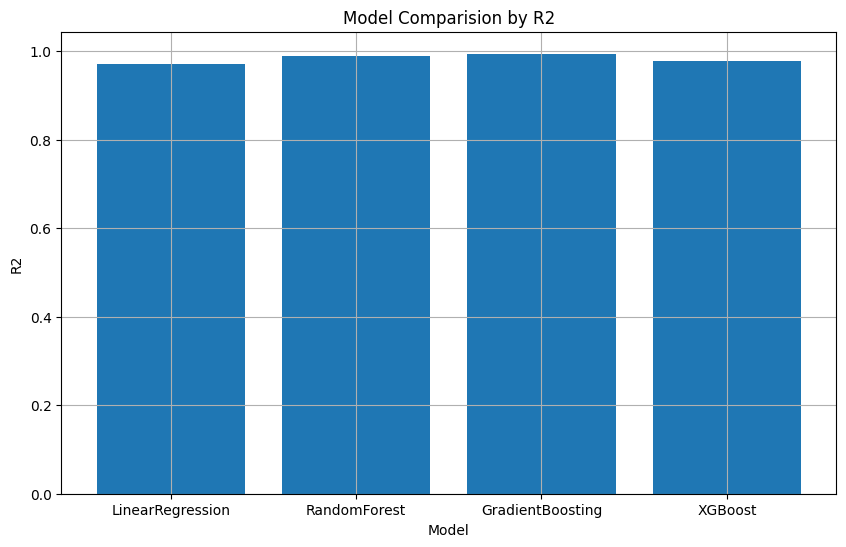

In [41]:
plot_model_metrics(results=results, metric='r2')

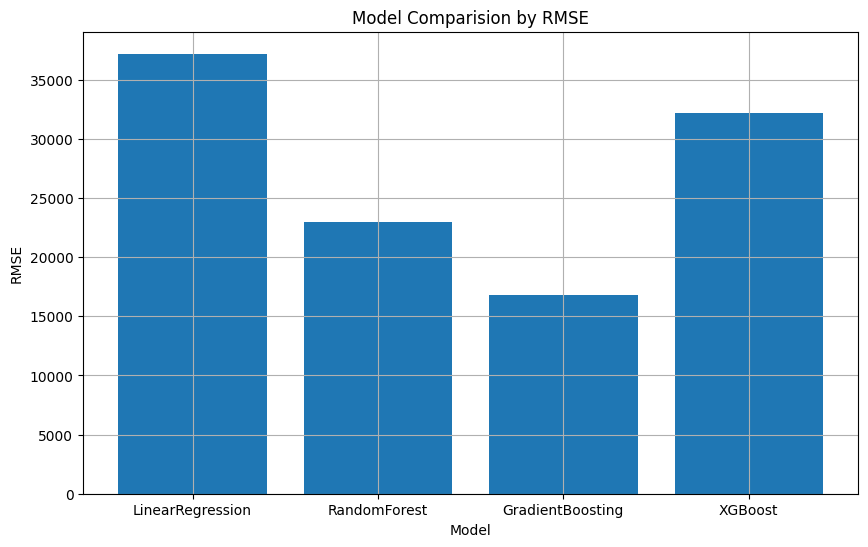

In [42]:
plot_model_metrics(results=results, metric='rmse')


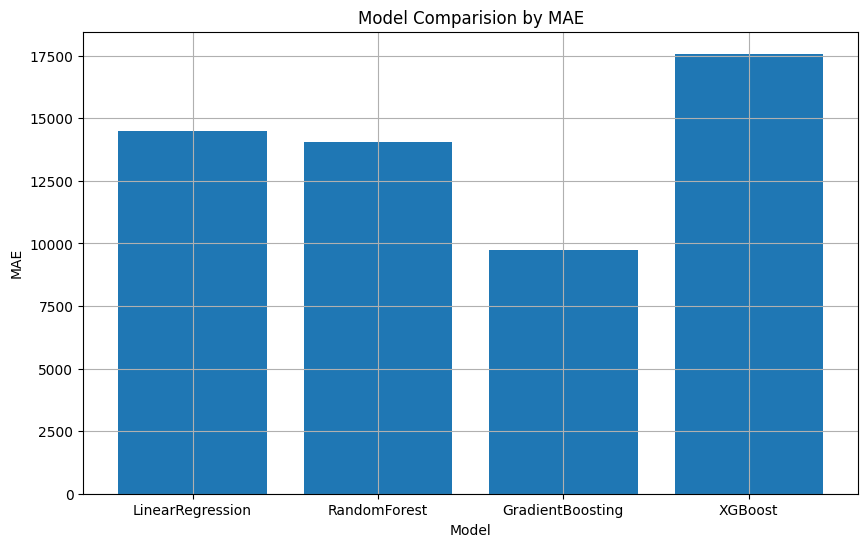

In [43]:
plot_model_metrics(results=results, metric='mae')

In [47]:
best_model_name=max(results,key=lambda x:results[x]['r2'])
best_model_name

'GradientBoosting'

In [48]:
best_model=results[best_model_name]['model']
best_model

GradientBoostingRegressor(n_estimators=250)

In [50]:
best_params=results[best_model_name]['params']
best_params

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}

In [51]:
best_r2=results[best_model_name]['r2']
best_r2

0.9939361783683615

In [52]:
best_mae=results[best_model_name]['mae']
best_mae

9722.979622028652

In [53]:
best_rmse=results[best_model_name]['rmse']
best_rmse

16806.231008231876

In [65]:
model_config={
    "model":{
        'name':'house_price_model',
        'best_model':best_model_name,
        'parameters':best_params,
        'r2_score':float(best_r2),
        'mae':float(best_mae),
        'target_variable':'price',
        'feature_sets':selected_features_dict
    }
}

model_config

{'model': {'name': 'house_price_model',
  'best_model': 'GradientBoosting',
  'parameters': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250},
  'r2_score': 0.9939361783683615,
  'mae': 9722.979622028652,
  'target_variable': 'price',
  'feature_sets': {'rfe': ['0',
    '1',
    '2',
    '3',
    '4',
    '6',
    '8',
    '9',
    '12',
    '14']}}}

In [66]:
config_path="../configs/model_config.yaml"
os.makedirs(name=os.path.dirname(p=config_path),exist_ok=True)
with open(file=config_path,mode='w') as f:
    yaml.dump(data=model_config,stream=f)

In [2]:
import mlflow

In [5]:
mlflow.MlflowClient

mlflow.tracking.client.MlflowClient